In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [344]:
pip install plotly wordcloud

Note: you may need to restart the kernel to use updated packages.


In [345]:
import json
from datetime import datetime
import plotly.express as px
from wordcloud import WordCloud

In [346]:
# Set up visualization style
plt.style.use('ggplot')
sns.set_palette("pastel")

In [347]:
df = pd.read_csv("E:/AICTE Intern Tasks/RISE/Datasets/6_Netflix.csv")
df.head()

,user_id,title,genre,watch_count,watch_hours,last_watched,rating,liked,device,age_group,viewing_history
0,U1,Forrest Gump,Drama,16,37.9,2025-03-31 10:31:25,NaN,False,smart-tv,36-45,"[{""timestamp"": ""2025-01-30 10:31"", ""duration_m..."
1,U2,The Silence of the Lambs,Thriller,19,37.4,2025-06-15 10:31:25,3.0,True,tablet,56+,"[{""timestamp"": ""2025-05-05 10:31"", ""duration_m..."
2,U3,Se7en,Thriller,15,31.8,2025-04-19 10:31:25,4.0,False,laptop,36-45,"[{""timestamp"": ""2025-03-17 10:31"", ""duration_m..."
3,U4,Inception,Sci-Fi,11,27.1,2025-06-12 10:31:25,1.0,True,mobile,36-45,"[{""timestamp"": ""2025-05-19 10:31"", ""duration_m..."
4,U5,The Godfather,Crime,10,29.2,2025-04-13 10:31:25,2.0,False,gaming-console,36-45,"[{""timestamp"": ""2025-02-16 10:31"", ""duration_m..."


In [348]:
df.shape

(500, 11)

In [349]:
df.dtypes

user_id             object
title               object
genre               object
watch_count          int64
watch_hours        float64
last_watched        object
rating             float64
liked                 bool
device              object
age_group           object
viewing_history     object
dtype: object

In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          500 non-null    object 
 1   title            500 non-null    object 
 2   genre            500 non-null    object 
 3   watch_count      500 non-null    int64  
 4   watch_hours      500 non-null    float64
 5   last_watched     500 non-null    object 
 6   rating           419 non-null    float64
 7   liked            500 non-null    bool   
 8   device           500 non-null    object 
 9   age_group        500 non-null    object 
 10  viewing_history  500 non-null    object 
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 39.7+ KB


In [351]:
df.columns

Index(['user_id', 'title', 'genre', 'watch_count', 'watch_hours',
       'last_watched', 'rating', 'liked', 'device', 'age_group',
       'viewing_history'],
      dtype='object')

In [352]:
df.describe()

,watch_count,watch_hours,rating
count,500.000000,500.000000,419.000000
mean,10.666000,25.364600,3.026253
std,5.800494,14.292179,1.409733
min,1.000000,2.000000,1.000000
25%,6.000000,14.075000,2.000000
50%,10.000000,24.350000,3.000000
75%,16.000000,37.400000,4.000000
max,20.000000,58.300000,5.000000


In [353]:
# check for muissing values
df.isnull().sum()

user_id             0
title               0
genre               0
watch_count         0
watch_hours         0
last_watched        0
rating             81
liked               0
device              0
age_group           0
viewing_history     0
dtype: int64

In [354]:

# Data Cleaning
def clean_data(df):
    # Convert date columns to datetime
    df['last_watched'] = pd.to_datetime(df['last_watched'], format='%Y-%m-%d %H:%M:%S')
    
    # Parse viewing_history JSON
    def parse_history(history_str):
        try:
            return json.loads(history_str.replace("'", '"'))
        except:
            return []
    
    df['viewing_history'] = df['viewing_history'].apply(parse_history)
    
    # Fill missing ratings with median rating per genre
    genre_medians = df.groupby('genre')['rating'].median()
    df['rating'] = df.apply(
        lambda row: genre_medians[row['genre']] if pd.isna(row['rating']) else row['rating'],
        axis=1
    )
    
    # Calculate additional metrics
    df['total_sessions'] = df['viewing_history'].apply(len)
    df['avg_session_min'] = df.apply(
        lambda row: sum([s['duration_min'] for s in row['viewing_history']])/len(row['viewing_history']) 
        if len(row['viewing_history']) > 0 else 0,
        axis=1
    )
    
    # Categorize binge behavior
    conditions = [
        (df['total_sessions'] >= 5) & (df['avg_session_min'] >= 60),
        (df['total_sessions'] >= 3) & (df['avg_session_min'] >= 45),
        (df['total_sessions'] >= 2) & (df['avg_session_min'] >= 30)
    ]
    choices = ['High Binge', 'Medium Binge', 'Low Binge']
    df['binge_category'] = np.select(conditions, choices, default='Non-Binge')
    
    return df

data = clean_data(df)

In [355]:
data.head()

,user_id,title,genre,watch_count,watch_hours,last_watched,rating,liked,device,age_group,viewing_history,total_sessions,avg_session_min,binge_category
0,U1,Forrest Gump,Drama,16,37.9,2025-03-31 10:31:25,2.5,False,smart-tv,36-45,"[{'timestamp': '2025-01-30 10:31', 'duration_m...",5,79.0,High Binge
1,U2,The Silence of the Lambs,Thriller,19,37.4,2025-06-15 10:31:25,3.0,True,tablet,56+,"[{'timestamp': '2025-05-05 10:31', 'duration_m...",1,55.0,Non-Binge
2,U3,Se7en,Thriller,15,31.8,2025-04-19 10:31:25,4.0,False,laptop,36-45,"[{'timestamp': '2025-03-17 10:31', 'duration_m...",2,50.5,Low Binge
3,U4,Inception,Sci-Fi,11,27.1,2025-06-12 10:31:25,1.0,True,mobile,36-45,"[{'timestamp': '2025-05-19 10:31', 'duration_m...",2,52.5,Low Binge
4,U5,The Godfather,Crime,10,29.2,2025-04-13 10:31:25,2.0,False,gaming-console,36-45,"[{'timestamp': '2025-02-16 10:31', 'duration_m...",2,94.5,Low Binge


In [356]:
data = data.to_csv("E:/AICTE Intern Tasks/RISE/Datasets/6_Cleaned_NetflixData.csv", index=False)

In [357]:
data = pd.read_csv("E:/AICTE Intern Tasks/RISE/Datasets/6_Cleaned_NetflixData.csv")
data.head()

,user_id,title,genre,watch_count,watch_hours,last_watched,rating,liked,device,age_group,viewing_history,total_sessions,avg_session_min,binge_category
0,U1,Forrest Gump,Drama,16,37.9,2025-03-31 10:31:25,2.5,False,smart-tv,36-45,"[{'timestamp': '2025-01-30 10:31', 'duration_m...",5,79.0,High Binge
1,U2,The Silence of the Lambs,Thriller,19,37.4,2025-06-15 10:31:25,3.0,True,tablet,56+,"[{'timestamp': '2025-05-05 10:31', 'duration_m...",1,55.0,Non-Binge
2,U3,Se7en,Thriller,15,31.8,2025-04-19 10:31:25,4.0,False,laptop,36-45,"[{'timestamp': '2025-03-17 10:31', 'duration_m...",2,50.5,Low Binge
3,U4,Inception,Sci-Fi,11,27.1,2025-06-12 10:31:25,1.0,True,mobile,36-45,"[{'timestamp': '2025-05-19 10:31', 'duration_m...",2,52.5,Low Binge
4,U5,The Godfather,Crime,10,29.2,2025-04-13 10:31:25,2.0,False,gaming-console,36-45,"[{'timestamp': '2025-02-16 10:31', 'duration_m...",2,94.5,Low Binge


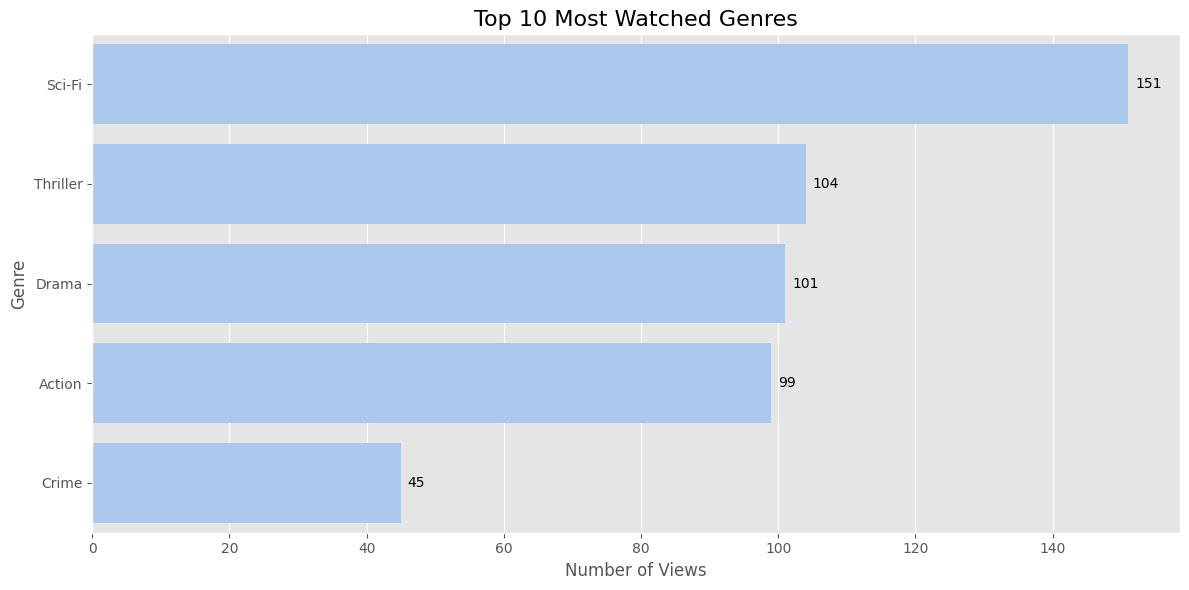

In [358]:
# 1. Top Genres Analysis
def plot_top_genres(data):
    genre_counts = data['genre'].value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=genre_counts.values, y=genre_counts.index)
    plt.title('Top 10 Most Watched Genres', fontsize=16)
    plt.xlabel('Number of Views', fontsize=12)
    plt.ylabel('Genre', fontsize=12)
    
    # Add value annotations
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 1, p.get_y() + p.get_height()/2, f'{int(width)}', ha='left', va='center')
    
    plt.tight_layout()
    plt.savefig("E:/AICTE Intern Tasks/RISE/PNG files/top_genres.png", dpi=300)
    plt.show()

    return data
    
data = plot_top_genres(data)    

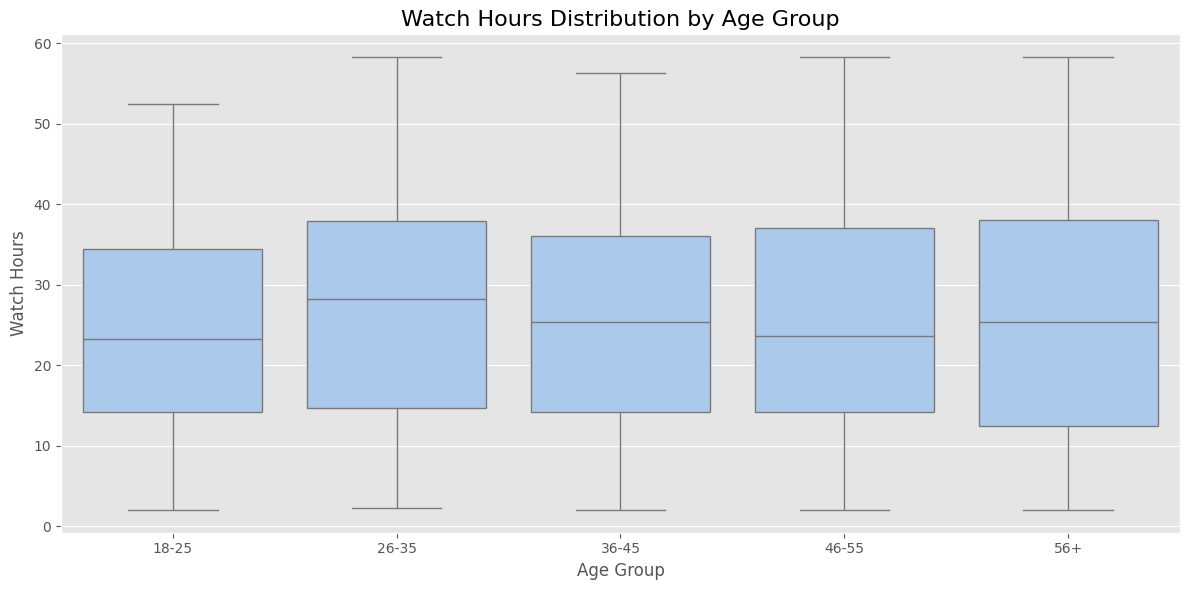

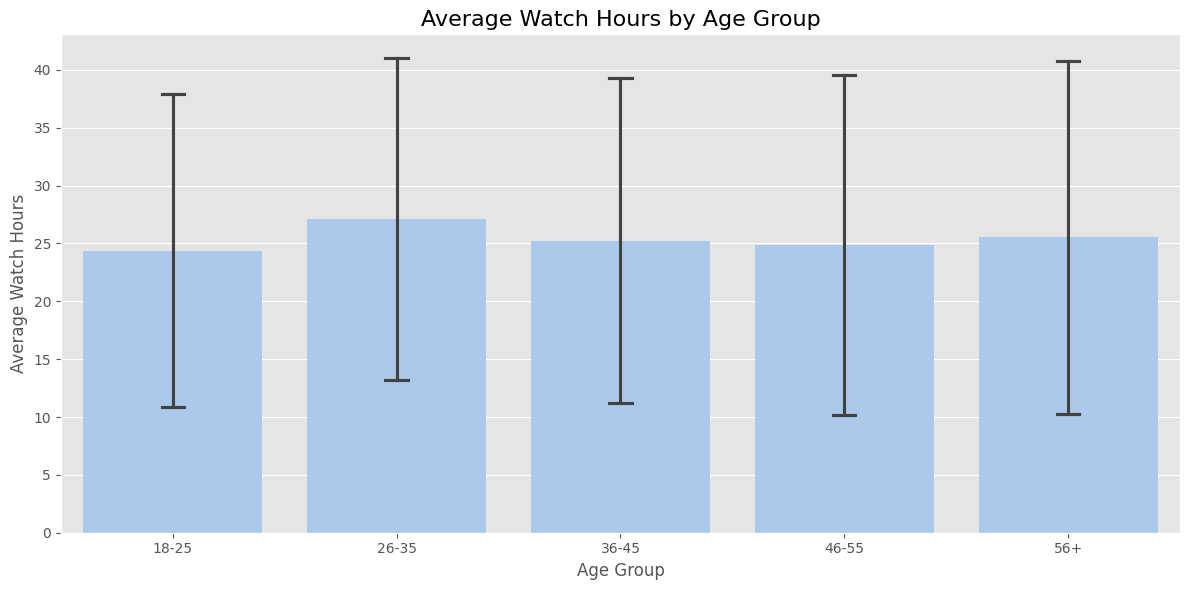

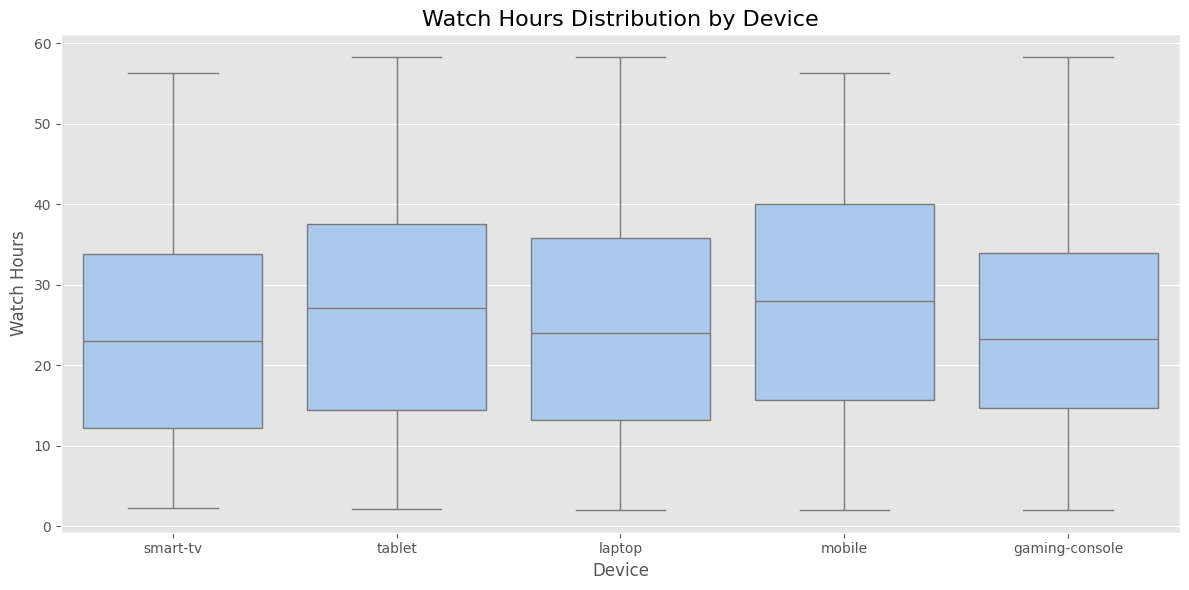

In [359]:
# 2. Watch Hours Analysis
def plot_watch_hours(data):
    # Ensure age_group is categorical with correct order
    age_order = ["18-25", "26-35", "36-45", "46-55", "56+"]
    data['age_group'] = pd.Categorical(df['age_group'], categories=age_order, ordered=True)
    
    # Watch hours by age group
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='age_group', y='watch_hours', data=data, order=age_order)
    plt.title('Watch Hours Distribution by Age Group', fontsize=16)
    plt.xlabel('Age Group', fontsize=12)
    plt.ylabel('Watch Hours', fontsize=12)
    plt.tight_layout()
    plt.savefig('E:/AICTE Intern Tasks/RISE/PNG files/watch_hours_by_age.png', dpi=300)
    plt.show()
    
    # Alternative visualization - bar plot with error bars
    plt.figure(figsize=(12, 6))
    sns.barplot(x='age_group', y='watch_hours', data=df, order=age_order, errorbar='sd', capsize=0.1)
    plt.title('Average Watch Hours by Age Group', fontsize=16)
    plt.xlabel('Age Group', fontsize=12)
    plt.ylabel('Average Watch Hours', fontsize=12)
    plt.tight_layout()
    plt.savefig('E:/AICTE Intern Tasks/RISE/PNG files/avg_watch_hours_by_age.png', dpi=300)
    plt.show()
    
    # Watch hours by device
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='device', y='watch_hours', data=df)
    plt.title('Watch Hours Distribution by Device', fontsize=16)
    plt.xlabel('Device', fontsize=12)
    plt.ylabel('Watch Hours', fontsize=12)
    plt.tight_layout()
    plt.savefig('E:/AICTE Intern Tasks/RISE/PNG files/watch_hours_by_device.png', dpi=300)
    plt.show()

    return data 

# df = pd.read_csv("E:/AICTE Intern Tasks/RISE/Datasets/6_Netflix.csv")
data = plot_watch_hours(data)  

<Figure size 1400x800 with 0 Axes>

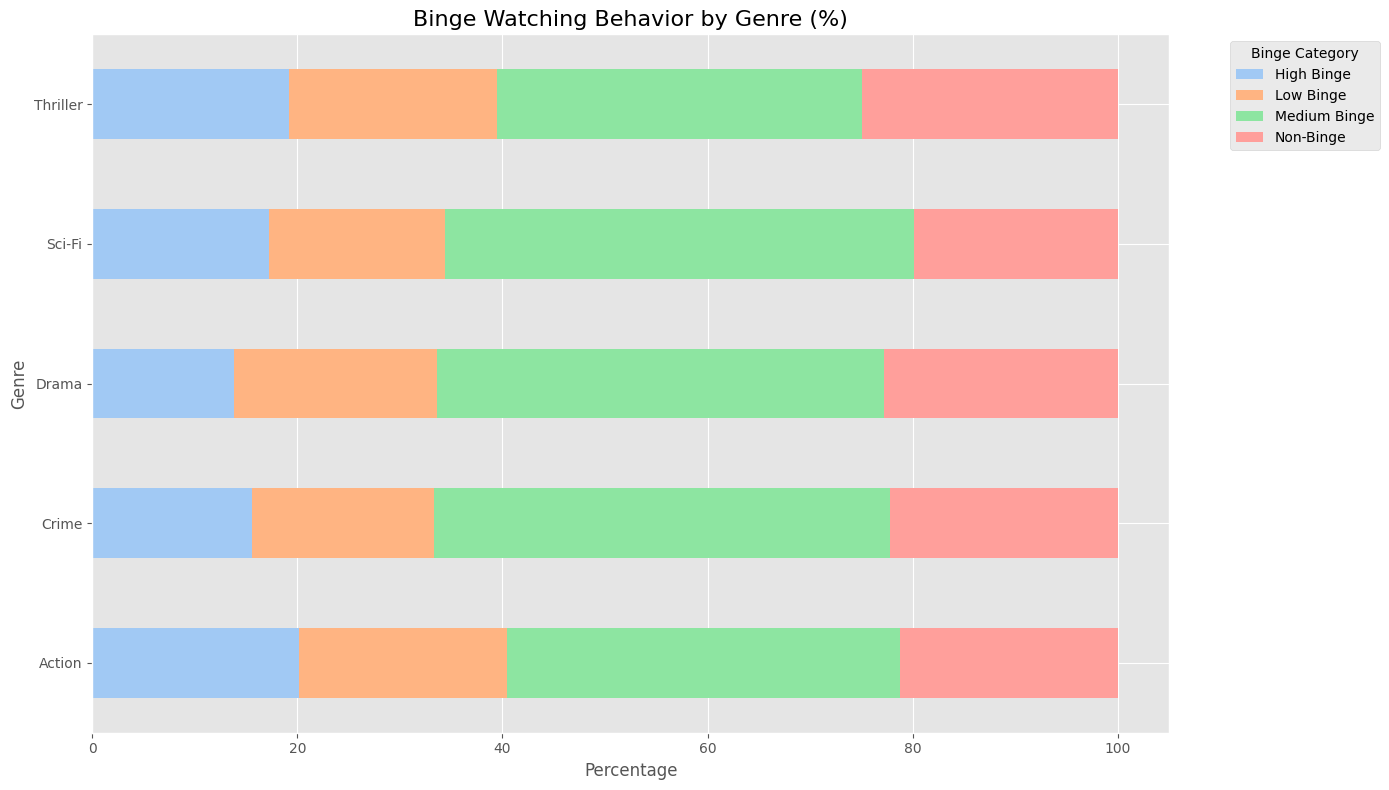

In [360]:
# 3. Binge Behavior Analysis
def plot_binge_behavior(data):
    # Binge behavior by genre
    binge_by_genre = pd.crosstab(data['genre'], data['binge_category'], normalize='index') * 100
    
    plt.figure(figsize=(14, 8))
    binge_by_genre.plot(kind='barh', stacked=True, figsize=(14, 8))
    plt.title('Binge Watching Behavior by Genre (%)', fontsize=16)
    plt.xlabel('Percentage', fontsize=12)
    plt.ylabel('Genre', fontsize=12)
    plt.legend(title='Binge Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('E:/AICTE Intern Tasks/RISE/PNG files/binge_by_genre.png', dpi=300)
    plt.show()
    
    # Interactive bubble chart of binge behavior
    binge_stats = df.groupby(['genre', 'binge_category']).size().reset_index(name='counts')
    fig = px.scatter(binge_stats, x='genre', y='counts', size='counts', color='binge_category',
                     hover_name='genre', size_max=60,
                     title='Binge Watching Behavior Across Genres')
    fig.write_html('binge_interactive.html')
    fig.show()

data = plot_binge_behavior(data)

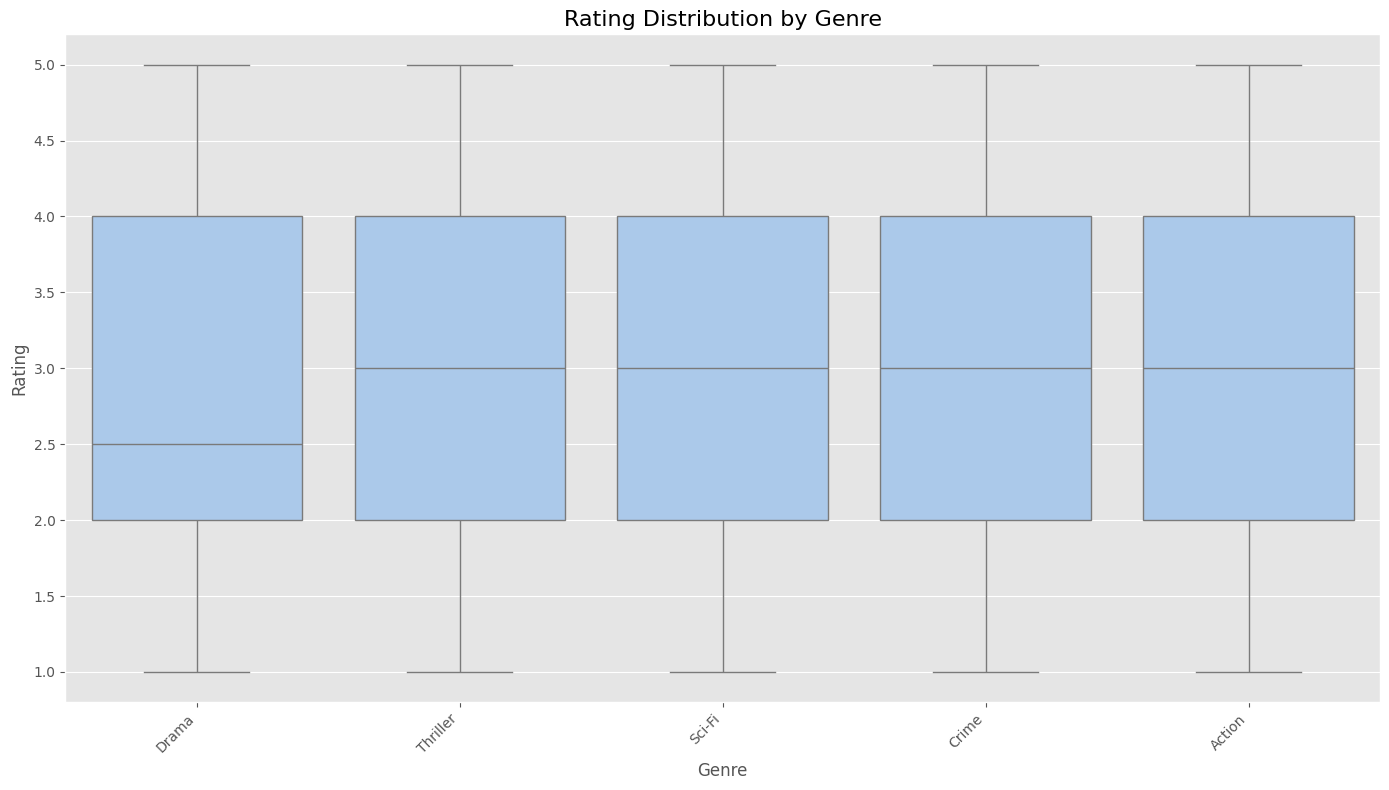

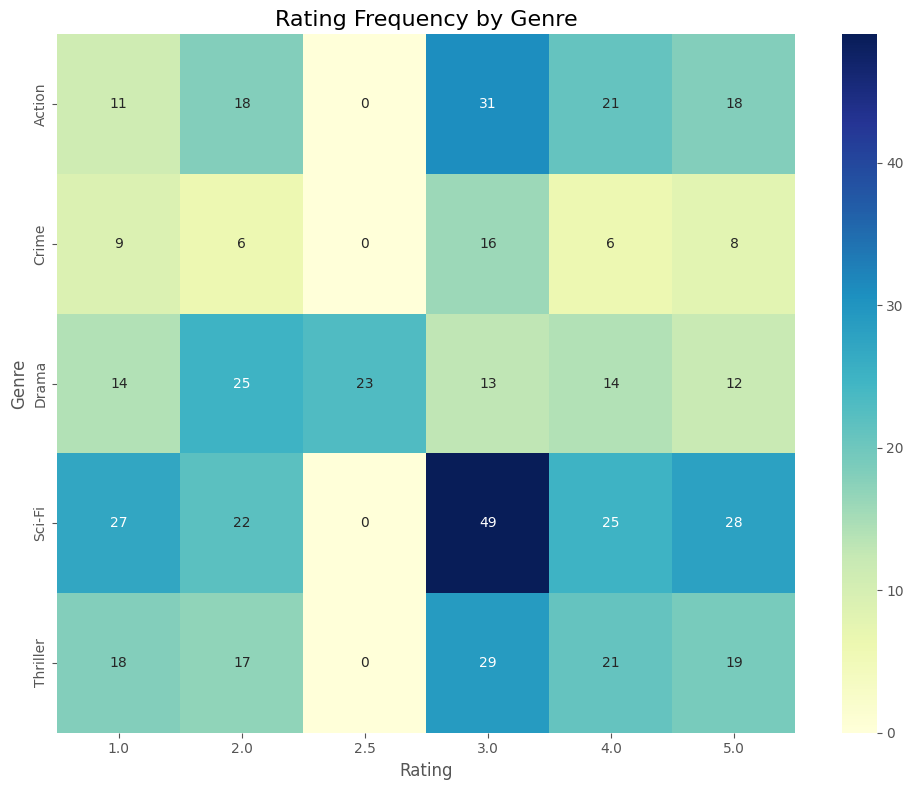

In [361]:
# 4. Ratings Analysis
def plot_ratings_analysis(data):
    # Ratings distribution by genre
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='genre', y='rating', data=data)
    plt.title('Rating Distribution by Genre', fontsize=16)
    plt.xlabel('Genre', fontsize=12)
    plt.ylabel('Rating', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('E:/AICTE Intern Tasks/RISE/PNG files/ratings_by_genre.png', dpi=300)
    plt.show()
    
    # Heatmap of ratings vs. watch hours
    plt.figure(figsize=(10, 8))
    pivot_table = data.pivot_table(index='genre', columns='rating', values='watch_hours', aggfunc='count', fill_value=0)
    sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='d')
    plt.title('Rating Frequency by Genre', fontsize=16)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Genre', fontsize=12)
    plt.tight_layout()
    plt.savefig('E:/AICTE Intern Tasks/RISE/PNG files/ratings_heatmap.png', dpi=300)
    plt.show()
    
data = pd.read_csv("E:/AICTE Intern Tasks/RISE/Datasets/6_Cleaned_NetflixData.csv")
data = plot_ratings_analysis(data)

Before conversion:
0    2025-03-31 10:31:25
1    2025-06-15 10:31:25
2    2025-04-19 10:31:25
3    2025-06-12 10:31:25
4    2025-04-13 10:31:25
Name: last_watched, dtype: object

Data types:
user_id             object
title               object
genre               object
watch_count          int64
watch_hours        float64
last_watched        object
rating             float64
liked                 bool
device              object
age_group           object
viewing_history     object
total_sessions       int64
avg_session_min    float64
binge_category      object
dtype: object


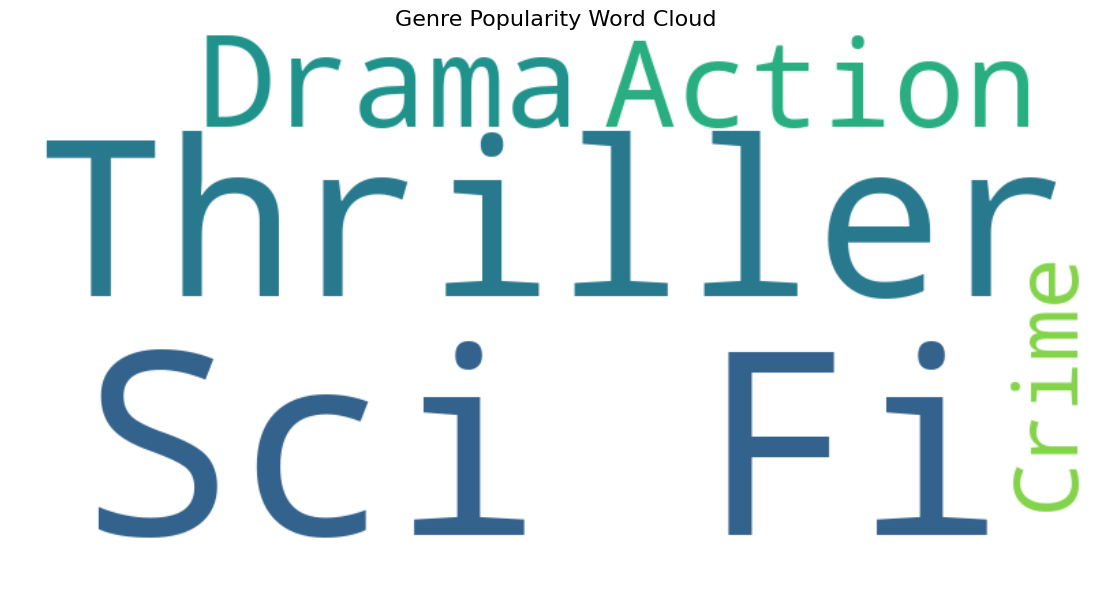

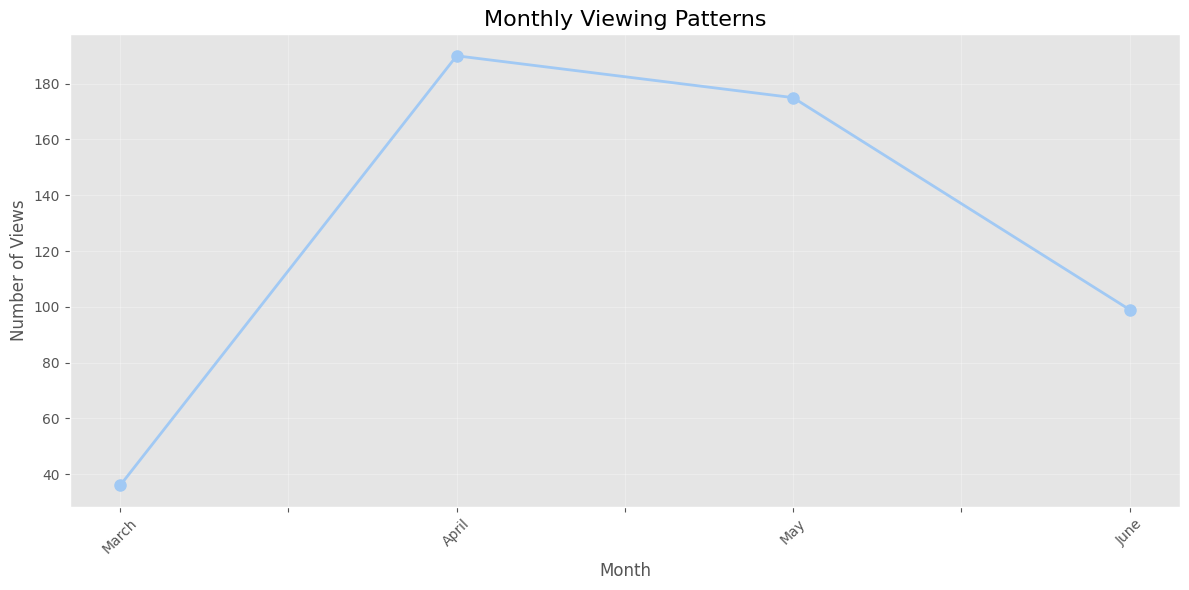


After conversion:
0   2025-03-31 10:31:25
1   2025-06-15 10:31:25
2   2025-04-19 10:31:25
3   2025-06-12 10:31:25
4   2025-04-13 10:31:25
Name: last_watched, dtype: datetime64[ns]


In [362]:
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def advanced_visualizations(data):
    """
    Generate advanced visualizations including word cloud and temporal analysis
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing 'genre' and 'last_watched' columns
    """
    
    # 1. Word Cloud of Genres
    try:
        # Combine all genres into a single string
        text = ' '.join(df['genre'].astype(str).dropna())
        
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100).generate(text)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Genre Popularity Word Cloud', fontsize=16)
        plt.tight_layout()
        plt.savefig('E:/AICTE Intern Tasks/RISE/PNG files/genre_wordcloud.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"Error generating word cloud: {str(e)}")
    
    # 2. Temporal Analysis
    try:
        # Convert last_watched to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(data['last_watched']):            
            data['last_watched'] = pd.to_datetime(data['last_watched'], errors='coerce')
        
        temp_df = df.dropna(subset=['last_watched'])
        
        if len(temp_df) == 0:
            raise ValueError("No valid datetime values in 'last_watched' column")
        
        temp_df['watch_month'] = temp_df['last_watched'].dt.month_name()
        
        # Count views by month in correct order
        month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                     'July', 'August', 'September', 'October', 'November', 'December']
        monthly_watch = temp_df.groupby('watch_month').size().reindex(month_order)
        
        # Plot monthly viewing patterns
        plt.figure(figsize=(12, 6))
        monthly_watch.plot(kind='line', marker='o', linewidth=2, markersize=8)
        plt.title('Monthly Viewing Patterns', fontsize=16)
        plt.xlabel('Month', fontsize=12)
        plt.ylabel('Number of Views', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('E:/AICTE Intern Tasks/RISE/PNG files/monthly_patterns.png', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error in temporal analysis: {str(e)}")    
    return data

data = pd.read_csv("E:/AICTE Intern Tasks/RISE/Datasets/6_Cleaned_NetflixData.csv")

print("Before conversion:")
print(data['last_watched'].head())
print("\nData types:")
print(data.dtypes)

data = advanced_visualizations(data)

if 'last_watched' in data.columns:
    print("\nAfter conversion:")
    print(data['last_watched'].head())

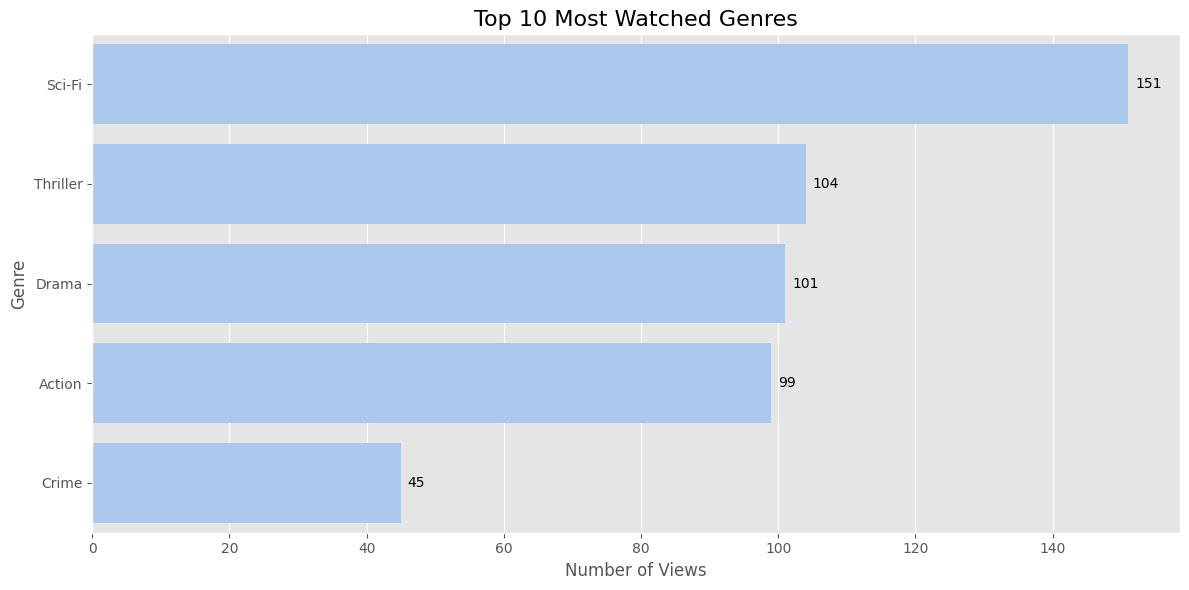

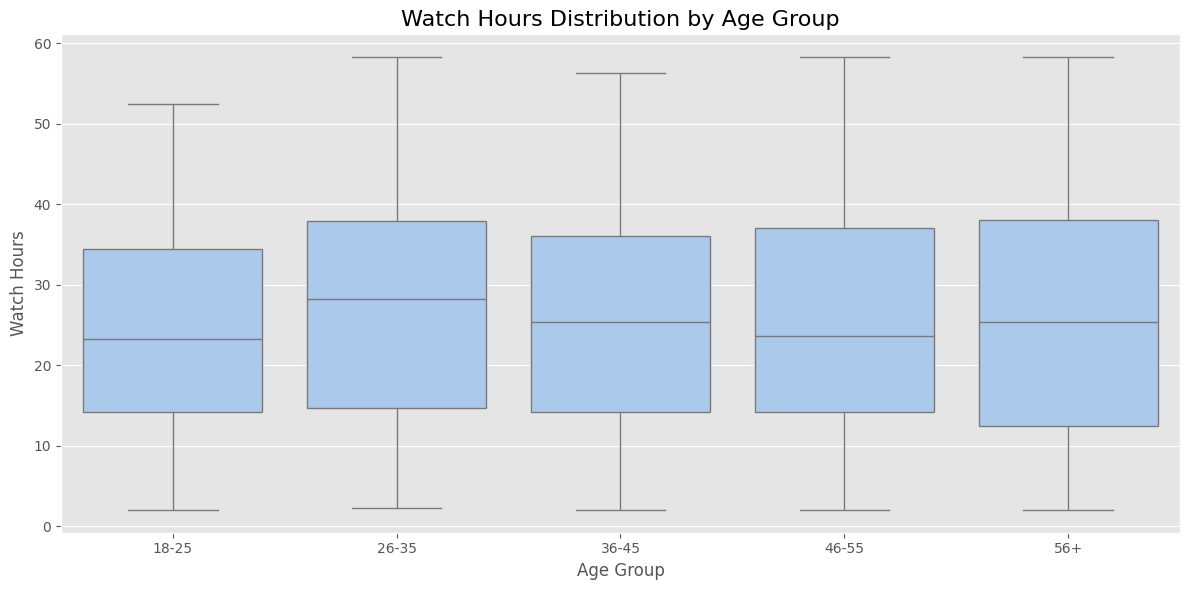

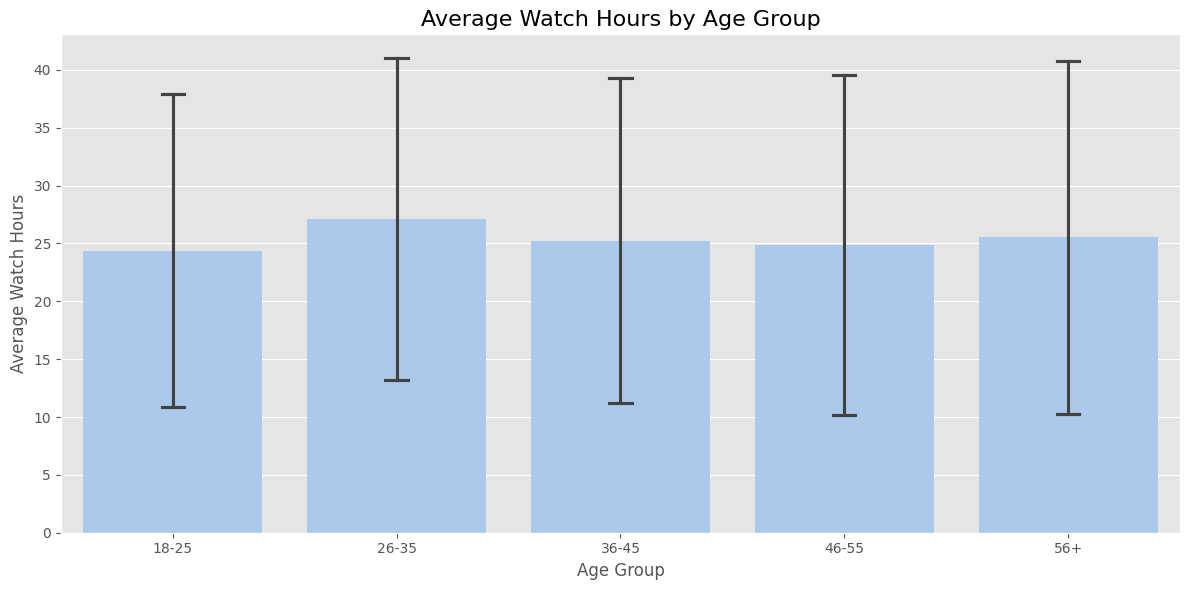

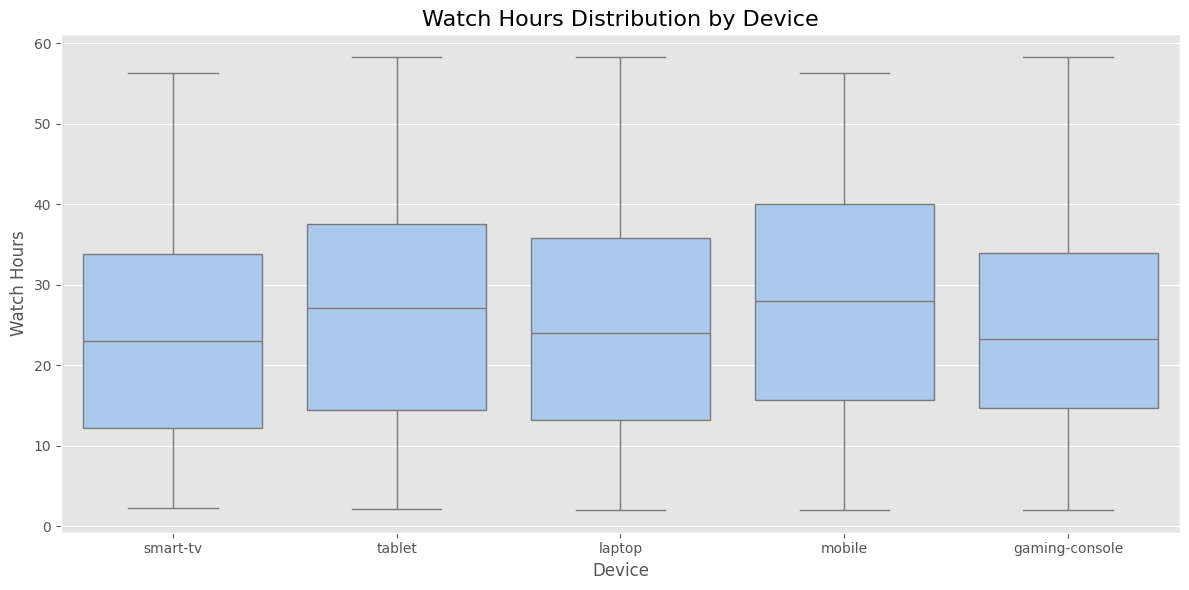

<Figure size 1400x800 with 0 Axes>

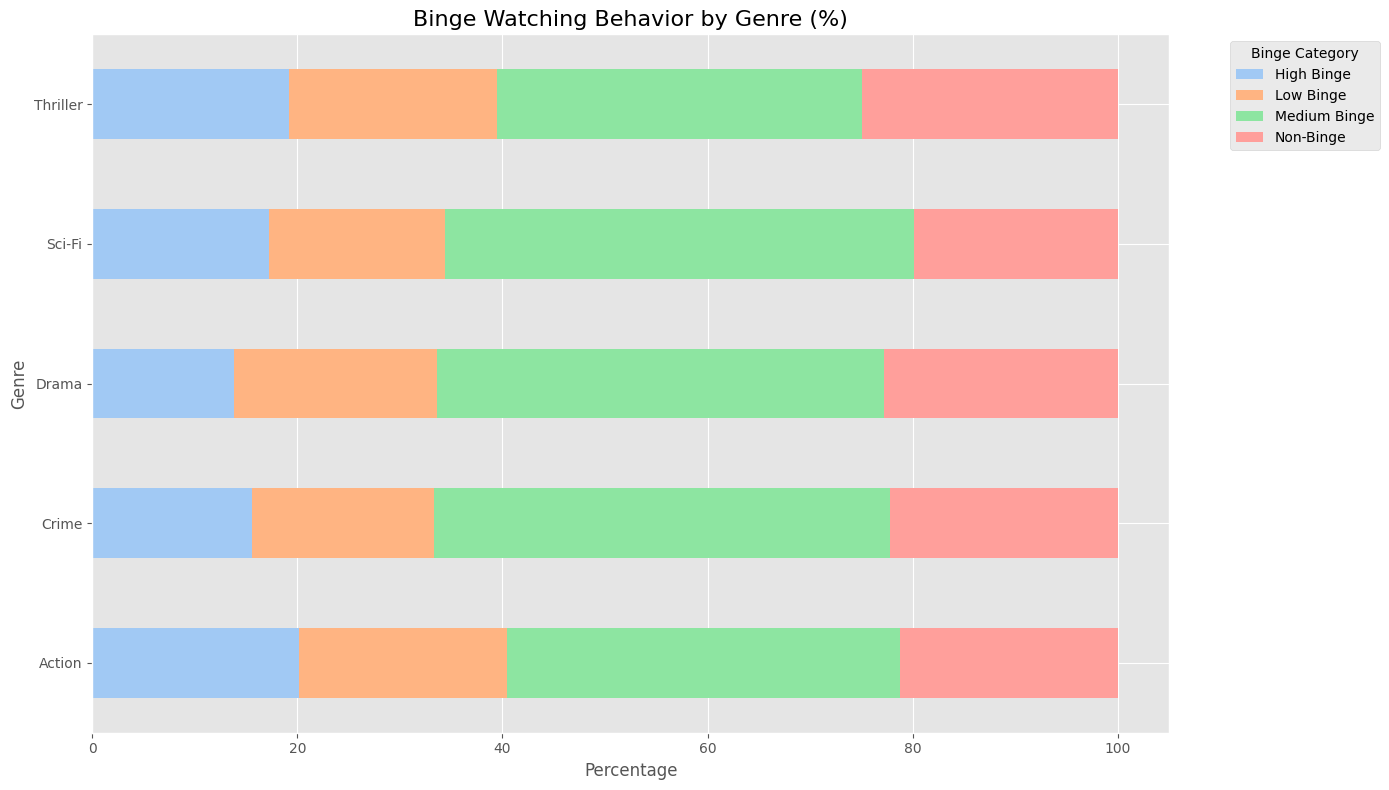

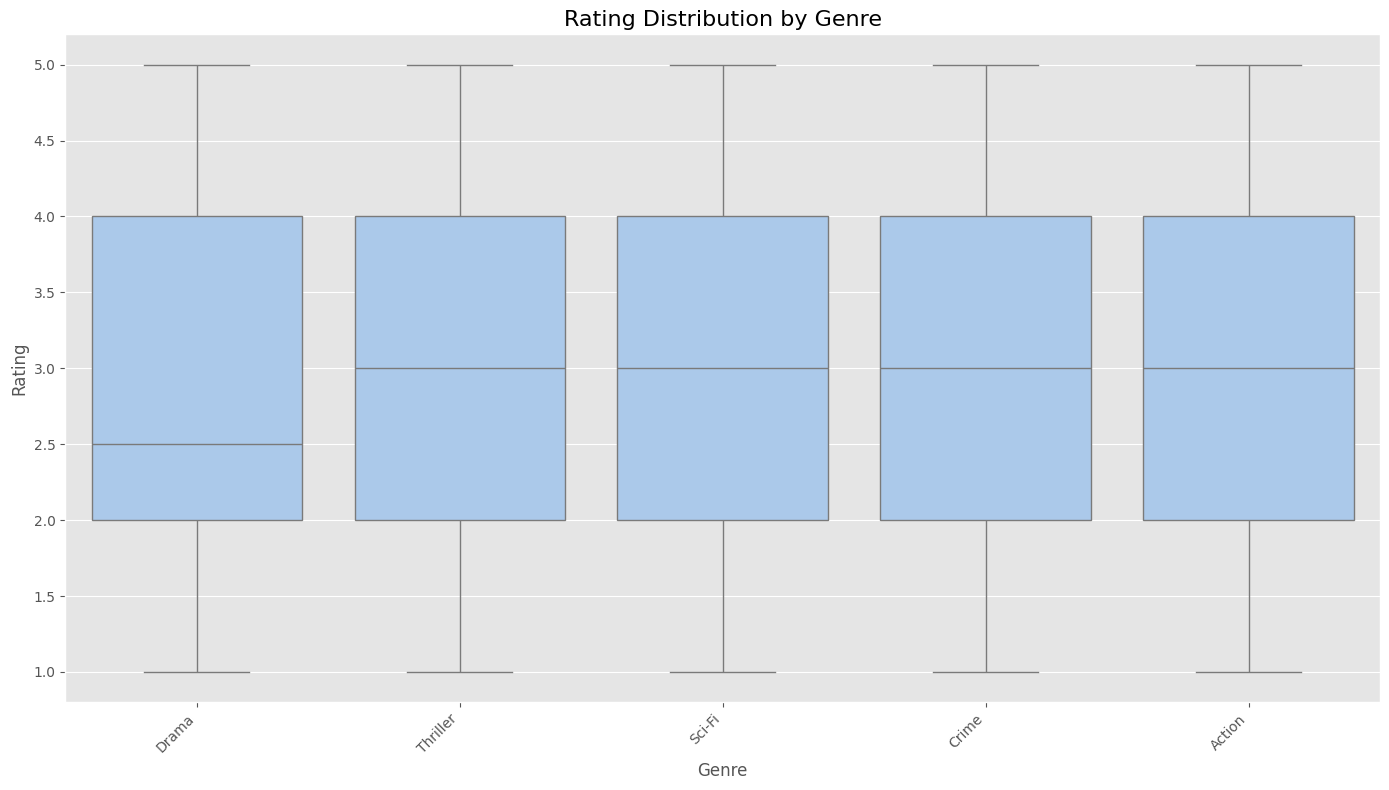

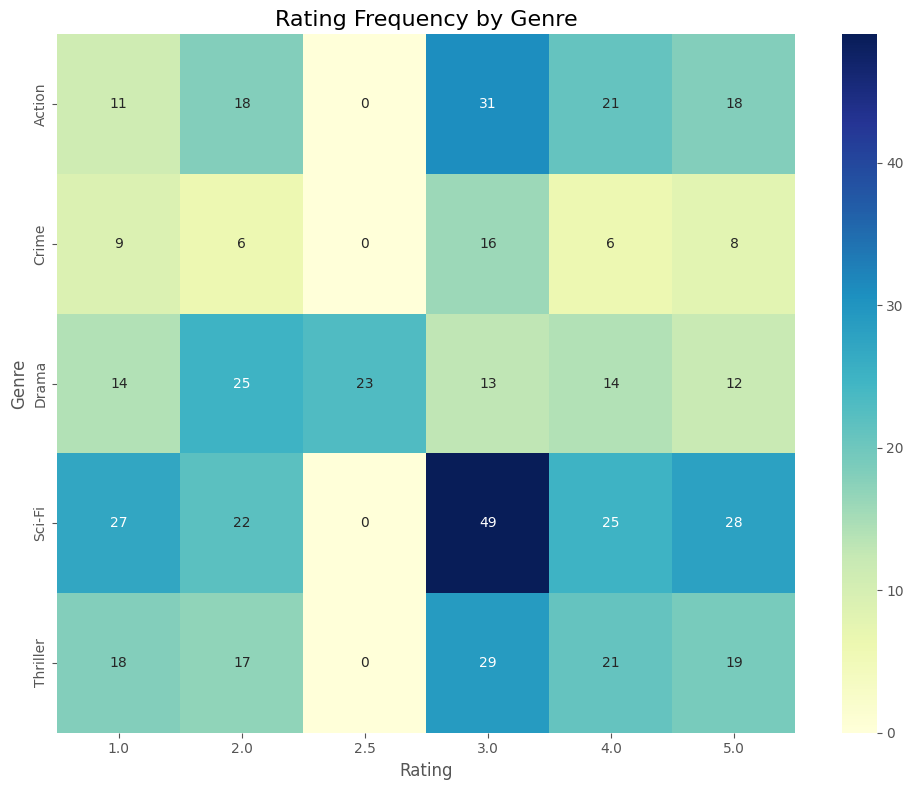

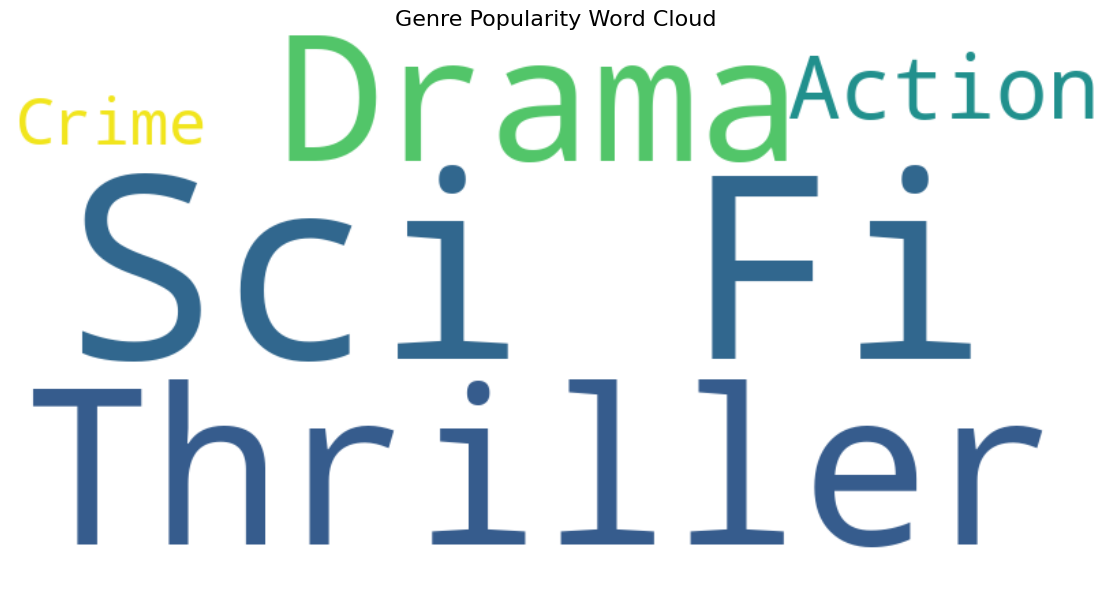

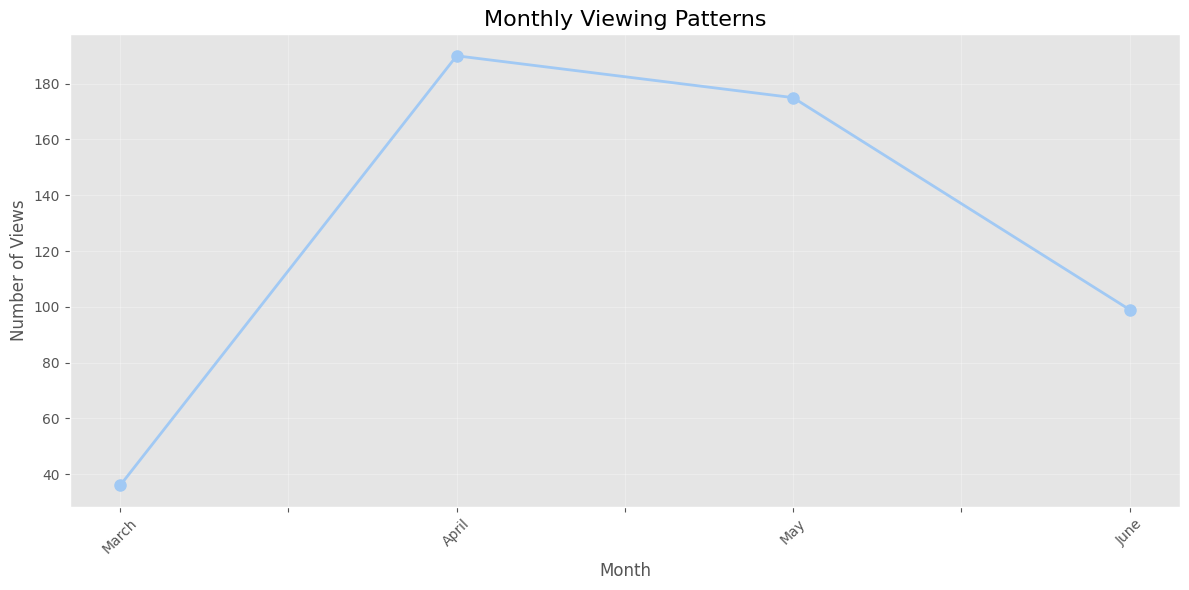

,user_id,title,genre,watch_count,watch_hours,last_watched,rating,liked,device,age_group,viewing_history,total_sessions,avg_session_min,binge_category
0,U1,Forrest Gump,Drama,16,37.9,2025-03-31 10:31:25,2.5,False,smart-tv,36-45,"[{'timestamp': '2025-01-30 10:31', 'duration_m...",5,79.000000,High Binge
1,U2,The Silence of the Lambs,Thriller,19,37.4,2025-06-15 10:31:25,3.0,True,tablet,56+,"[{'timestamp': '2025-05-05 10:31', 'duration_m...",1,55.000000,Non-Binge
2,U3,Se7en,Thriller,15,31.8,2025-04-19 10:31:25,4.0,False,laptop,36-45,"[{'timestamp': '2025-03-17 10:31', 'duration_m...",2,50.500000,Low Binge
3,U4,Inception,Sci-Fi,11,27.1,2025-06-12 10:31:25,1.0,True,mobile,36-45,"[{'timestamp': '2025-05-19 10:31', 'duration_m...",2,52.500000,Low Binge
4,U5,The Godfather,Crime,10,29.2,2025-04-13 10:31:25,2.0,False,gaming-console,36-45,"[{'timestamp': '2025-02-16 10:31', 'duration_m...",2,94.500000,Low Binge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,U496,The Shawshank Redemption,Drama,18,42.6,2025-04-24 10:31:25,3.0,True,gaming-console,46-55,"[{'timestamp': '2025-03-21 10:31', 'duration_m...",2,120.000000,Low Binge
496,U497,The Matrix,Sci-Fi,20,45.3,2025-04-18 10:31:25,4.0,False,gaming-console,26-35,"[{'timestamp': '2025-04-08 10:31', 'duration_m...",1,79.000000,Non-Binge
497,U498,The Dark Knight,Action,12,30.4,2025-03-24 10:31:25,2.0,False,gaming-console,18-25,"[{'timestamp': '2025-03-12 10:31', 'duration_m...",4,62.000000,Medium Binge
498,U499,The Dark Knight,Action,6,15.2,2025-05-22 10:31:25,1.0,True,tablet,18-25,"[{'timestamp': '2025-04-03 10:31', 'duration_m...",3,97.666667,Medium Binge


In [363]:

# Generate all visualizations
plot_top_genres(data)
plot_watch_hours(data)
plot_binge_behavior(data)
plot_ratings_analysis(data)
advanced_visualizations(data)

In [364]:
print("\nKey Insights:")
print(f"1. Most popular genre: {df['genre'].value_counts().idxmax()}")
print(f"2. Average watch hours per user: {df['watch_hours'].mean():.1f} hours")
print(f"3. Highest rated genre: {df.groupby('genre')['rating'].mean().idxmax()}")
print(f"4. Binge watching percentage: {(df['binge_category'] != 'Non-Binge').mean()*100:.1f}%")
print(f"5. Most common device: {df['device'].value_counts().idxmax()}")


Key Insights:
1. Most popular genre: Sci-Fi
2. Average watch hours per user: 25.4 hours
3. Highest rated genre: Action
4. Binge watching percentage: 78.0%
5. Most common device: mobile
